# Adaptive A.B Testing

> Once you have more information, shouldn't you adapt?

Recently at Ellevest, we launched one of our largest, and I'd venture our most 1-sided A/B test. In full support of confirming assumptions with data, it was easy to agree to A/B test but shortly after launch (in the magnitude of hours) I suggested that we start adjusting our 50/50 split in favor of the new B. Note this was shifting, not full on decision making. It was far from statistically significant but we were starting to see B outperform. I was surprised when this was met with resistance even as I tried to explain what Adaptive A/B Testing can achieve. I temproary surrendered and wrapped up my day. I knew I had read about it in the context of clinical trials and thus brought it up with my wife who happens to have a penchant for remembering things, especially as they relate to medicine and statistics. She started bringing me study after study that described 'christmas tree testing' and 'adaptive clinical trials'. I didn't read them admittedly, the jargon was too much, but I felt I wanted the models to go a little more head to head and here we are.

In this little experiment we are looking at testing which model will get us a higher return* for our average participant. From a business perspective there are a couple goals we are stiving for. 

First, we want to be confident in our decision in picking a final variant. This is already done with ind. t-tests and thus we will continue to use that. 

Second, we don't want to be 'wasting' resources and time sending to A if B has a higher return. Thus we will not use binary success/failure but look to see if the mean returns of using even split, vs adaptive trials. This was the crux of why I requested we start shifting our weightings.

Third, we need to ensure the trial lengths are not statistically different. The logic here is that if the trial goes longer, even with a higher average return, the indecision is costing us by continuing to put cases in the less effective variant. This is the weakest of our three requirements and could be revisited.

So without further ado, lets get to some testing.

*1 'higher return' can mean many things, higher revenue, higher mortaility, etc. 

In [21]:
# Yup. Always need some imports.
import pandas as pd
import numpy as np
import scipy as sp
import math
ARB_CUTOFF = 6000 # to ensure we don't loop forever, allow 6k trials max

In [120]:
"""

Let's define our A and B variant outcomes. 
The assumptions we are making about the underlying population and how they react to the variants could have 
an impact on our test. Something to keep in mind before generalizing this too much.

"""

variant_a_mean_payout = 5
variant_b_mean_payout = 6

variant_a_stdev = 1
variant_b_stdev = 1

"""

We will use these methods as our 'random draw'. 
This is equivlant to someone landing on variant A or variant B and realizing the outcome.

"""
## Setup Variant Responses
def get_variant_A():
    return np.random.normal(loc=variant_a_mean_payout, scale=variant_a_stdev)

def get_variant_B():
    return np.random.normal(loc=variant_b_mean_payout, scale=variant_b_stdev)

In [121]:
"""
A/B test with 50/50 split. 

This is what most people are familiar with. 
"""
def even_split_weight_pick(_a, _b, weighting):
    return np.random.rand() < weighting

In [122]:
"""

A/B test with Adaptive split.

This is the adaptive split. 
1. Start with random 50/50 until we have a valid pvalue. 
2. If we have a pvalue start 'leaning' towards the variant that has the larger average return 
   with the weight being decided by the pvalue/confidence.
3. Repeat.

"""
def adaptive_weight_pick(a, b, weighting):
    pvalue = sp.stats.ttest_ind(a, b).pvalue
    rand = np.random.rand()

    # if not enough information, be random 50/50 A/B
    if math.isnan(pvalue):
        return rand > weighting
    
    # reshape pvalue 
    # p-value e [0, 1]
    # prob e [1, 0.5]
    conf = (pvalue + 1) / 2
    
    # lean towards 'a' w/confidence
    if np.mean(a) > np.mean(b):
        return rand > conf
    else:
        return rand < conf

In [123]:
"""

Our basic trial runs. Here we are realizing invidual outcomes sequentially and seeing if we have
statistical significance. If not, we keep the trial running. This achieves our 1st requirement
for the trials in that we are confident in picking our variant. 

"""
def run_trial(decision_function, weighting=0.5, stat_sig=0.05):
    p_value = 1

    var_A = []
    var_B = []
    trial_counts = 0

    while (p_value > stat_sig) and (trial_counts < ARB_CUTOFF):
        # implementation of decision_function
        if decision_function(var_A, var_B, weighting):
            var_A.append(get_variant_A())
        else:
            var_B.append(get_variant_B())
        
        p_value = sp.stats.ttest_ind(var_A, var_B).pvalue
        trial_counts = len(var_A) + len(var_B)
        if math.isnan(p_value):
            p_value = 1 # if not enough data, we have no significance

    # this is just me being bad at python... Taking the weighted average.
    average_A = np.mean(var_A) * len(var_A)
    average_B = np.mean(var_B) * len(var_B)
    average = (average_A + average_B) / trial_counts
    
    return [average, trial_counts]

In [124]:
"""
Run N number
"""
N = 1000
adaptive = [run_trial(adaptive_weight_pick) for _x in xrange(N)]
even = [run_trial(even_split_weight_pick) for _x in xrange(N)]

In [125]:
# pull out means to compare
adaptive_x = [item[0] for item in adaptive]
adaptive_trial = [item[1] for item in adaptive]
# pull out trial counts to compare
even_x = [item[0] for item in even]
even_trial = [item[1] for item in even]

In [126]:
# Conclusion
x_pvalue = sp.stats.ttest_ind(adaptive_x, even_x).pvalue
trial_pvalue = sp.stats.ttest_ind(adaptive_trial, even_trial).pvalue

print("\n")
print('----------')
print("Requirement 2: Exploring trial mean return.")
adaptive_sigificant = x_pvalue < 0.05
print("Is adaptive statistically significant? {r} (pvalue: {p})".format(r=(adaptive_sigificant), p=x_pvalue))
adaptive_greater = np.mean(adaptive_x) > np.mean(even_x)
print("Is adaptive returning higher?          {r} (A: {a} to E: {b})".format(r=(adaptive_greater), a=np.mean(adaptive_x), b=np.mean(even_x)))
print('----------')
print("\n")
print('----------')
print("Requirement 3: Exploring trial length.")
adaptive_sigificant = trial_pvalue < 0.05
print("Is adaptive statistically significant? {r} (pvalue: {p})".format(r=(adaptive_sigificant), p=trial_pvalue))
adaptive_greater = np.mean(adaptive_trial) > np.mean(even_trial)
print("Is adaptive longer?                    {r} (A: {a} to E: {b})".format(r=(adaptive_greater), a=np.mean(adaptive_trial), b=np.mean(even_trial)))
print('----------')
print("\n\n")



----------
Requirement 2: Exploring trial mean return.
Is adaptive statistically significant? True (pvalue: 3.92418204766e-06)
Is adaptive returning higher?          False (A: 5.43597217803 to E: 5.50366636241)
----------


----------
Requirement 3: Exploring trial length.
Is adaptive statistically significant? False (pvalue: 0.0599624994339)
Is adaptive longer?                    True (A: 19.765 to E: 18.522)
----------





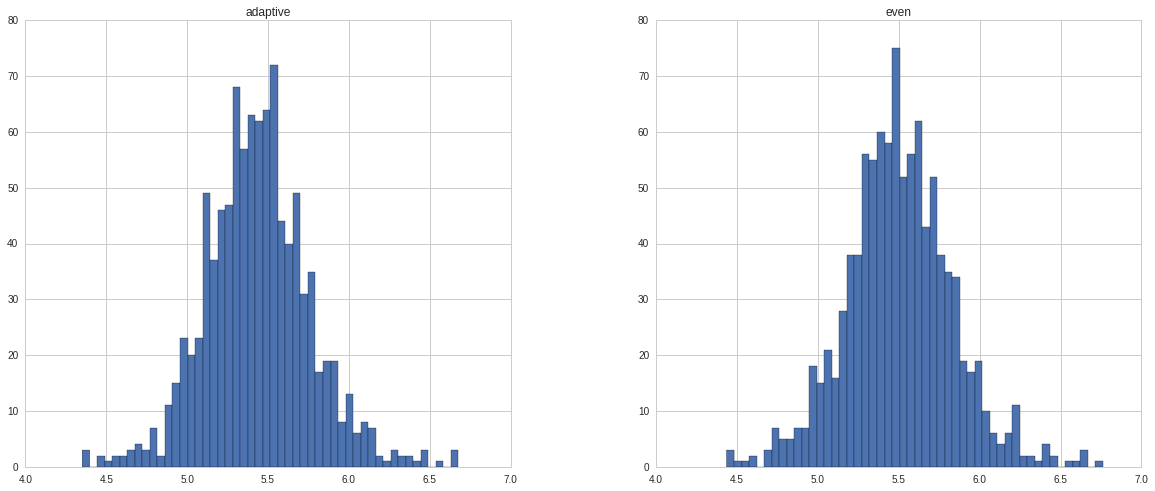

In [127]:
# Take a look at mean return
pd.DataFrame({
    'adaptive': adaptive_x,
    'even': even_x
}).hist(bins=50, sharex=True, figsize=(20,8));

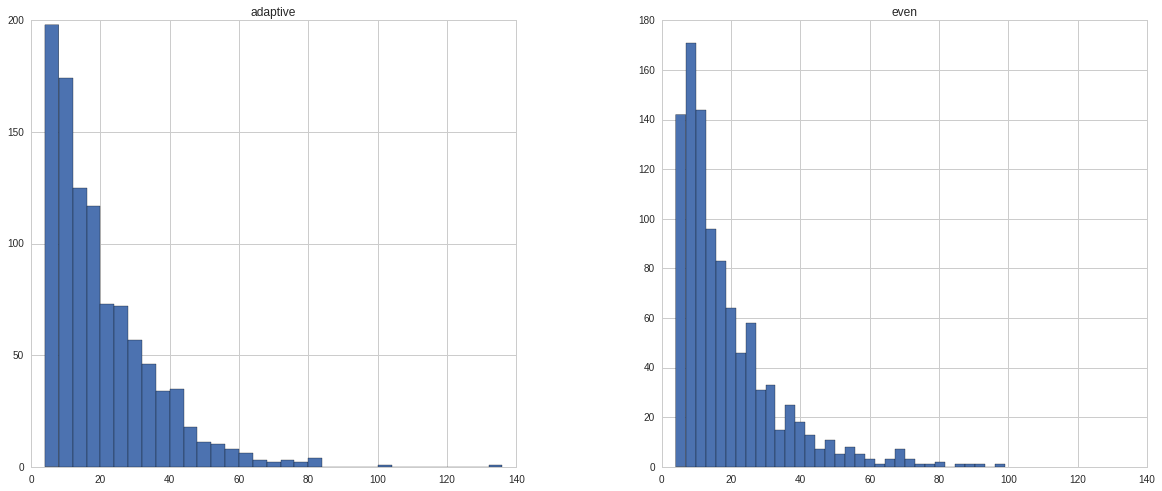

In [128]:
# Take a look at trial length
pd.DataFrame({
    'adaptive': adaptive_trial,
    'even': even_trial
}).hist(bins=N/30, sharex=True, figsize=(20,8));

### Conclusion

Certainly not as cut and dry as I would have expected or was preaching, but there is value in being adaptive (just maybe not in an A/B test)! Feel free to copy and play with your own assumptions!